# Premier League 2024/25 Season Data Scraper

This project provides a Python-based scraper designed to extract and present Premier League standings and player performance data from multiple APIs, including the [football-data.org API](https://www.football-data.org/documentation/quickstart). By automating data collection, this scraper facilitates efficient analysis and visualization of team and player performance during the 2024/25 Premier League season. 

## Data Extraction
The scraper sends requests to the Coinlore API to retrieve cryptocurrency data. It processes the JSON response to extract relevant data points. The extracted data is organized into a pandas DataFrame, making it easy to manipulate and analyze. The DataFrame includes columns for each data point provided by the API.

In [2]:
# Imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from dotenv import load_dotenv
%matplotlib inline

In [20]:
# Load environment variables from .env file
load_dotenv()

# API endpoints
COMPETITION_ID = 'PL'
BASE_URL_STANDINGS = f'http://api.football-data.org/v4/competitions/{COMPETITION_ID}/standings'
BASE_URL_TEAMS = 'http://api.football-data.org/v4/teams/{id}'
BASE_URL_SCORERS = f'http://api.football-data.org/v4/competitions/{COMPETITION_ID}/scorers'

# Headers
REQUEST_HEADER = {
    'X-Auth-Token': os.getenv("API_KEY"),
    'User-Agent': os.getenv("USER_AGENT"),
    'Accept-Language': 'en-US, en;q=0.5'
}

# Function to get standings
def get_standings(season=None):
    params = {'season': season}
    response = requests.get(url=BASE_URL_STANDINGS, headers=REQUEST_HEADER, params=params)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 429:
        print("Rate limit exceeded. Waiting before retrying...")
        time.sleep(60)  # Wait for 60 seconds before retrying
        return get_standings(season)
    else:
        print(f"Error: {response.status_code}")
        return None

# Function to get team details
def get_team(team_id):
    response = requests.get(url=BASE_URL_TEAMS.format(id=team_id), headers=REQUEST_HEADER)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 429:
        print("Rate limit exceeded. Waiting before retrying...")
        time.sleep(60)
        return get_team(team_id)
    else:
        print(f"Error: {response.status_code}")
        return None

# Function to get top scorers
def get_top_scorers(season=None):
    params = {'season': season}
    response = requests.get(url=BASE_URL_SCORERS, headers=REQUEST_HEADER, params=params)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 429:
        print("Rate limit exceeded. Waiting before retrying...")
        time.sleep(60)
        return get_top_scorers(season)
    else:
        print(f"Error: {response.status_code}")
        return None

# Fetch data
standings_data = get_standings(season=2024)
scorers_data = get_top_scorers(season=2024)

# Combine data
if standings_data and scorers_data:
    standings_df = pd.DataFrame(standings_data['standings'][0]['table'])
    scorers_df = pd.DataFrame(scorers_data['scorers'])

    # Add coach, top scorer, goals, and penalties to standings
    standings_df['coach'] = None
    standings_df['top_scorer'] = None
    standings_df['goals'] = 0
    standings_df['penalties'] = 0

    for index, row in standings_df.iterrows():
        team_id = row['team']['id']
        
        # Get team details
        team_data = get_team(team_id)
        if team_data:
            coach_name = team_data.get('coach', {}).get('name', 'Unknown')
            standings_df.at[index, 'coach'] = coach_name
        
        # Get top scorer for the team
        team_scorers = scorers_df[scorers_df['team'].apply(lambda x: x.get('id') == team_id if isinstance(x, dict) else False)]
        if not team_scorers.empty:
            top_scorer_name = team_scorers.iloc[0]['player']['name']
            goals = team_scorers.iloc[0]['goals']
            assists = team_scorers.iloc[0]['assists']
            penalties = team_scorers.iloc[0].get('penalties', 0)
            standings_df.at[index, 'top_scorer'] = top_scorer_name
            standings_df.at[index, 'goals'] = goals
            standings_df.at[index, 'assists'] = assists
            standings_df.at[index, 'penalties'] = penalties
else:
    print("Failed to retrieve data.")

Rate limit exceeded. Waiting before retrying...


In [21]:
# Display extracted values
df = standings_df
df.head()

,position,team,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,coach,top_scorer,goals,penalties,assists
0,1,"{'id': 64, 'name': 'Liverpool FC', 'shortName'...",29,"W,W,W,D,W",21,7,1,70,69,27,42,Arne Slot,Mohamed Salah,27,9.0,16.0
1,2,"{'id': 57, 'name': 'Arsenal FC', 'shortName': ...",29,"W,D,D,L,W",16,10,3,58,53,24,29,Mikel Arteta,None,0,0.0,NaN
2,3,"{'id': 351, 'name': 'Nottingham Forest FC', 's...",29,"W,W,D,L,L",16,6,7,54,49,35,14,Nuno Espírito Santo,Chris Wood,18,3.0,3.0
3,4,"{'id': 61, 'name': 'Chelsea FC', 'shortName': ...",29,"L,W,W,L,L",14,7,8,49,53,37,16,Enzo Maresca,Cole Palmer,14,3.0,6.0
4,5,"{'id': 65, 'name': 'Manchester City FC', 'shor...",29,"D,L,W,L,W",14,6,9,48,55,40,15,Pep Guardiola,Erling Haaland,21,2.0,3.0


In [22]:
# Extract only the name from team column
df['team'] = df['team'].apply(lambda x: x['name'] if isinstance(x, dict) else None) 
df.head()

,position,team,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,coach,top_scorer,goals,penalties,assists
0,1,Liverpool FC,29,"W,W,W,D,W",21,7,1,70,69,27,42,Arne Slot,Mohamed Salah,27,9.0,16.0
1,2,Arsenal FC,29,"W,D,D,L,W",16,10,3,58,53,24,29,Mikel Arteta,None,0,0.0,NaN
2,3,Nottingham Forest FC,29,"W,W,D,L,L",16,6,7,54,49,35,14,Nuno Espírito Santo,Chris Wood,18,3.0,3.0
3,4,Chelsea FC,29,"L,W,W,L,L",14,7,8,49,53,37,16,Enzo Maresca,Cole Palmer,14,3.0,6.0
4,5,Manchester City FC,29,"D,L,W,L,W",14,6,9,48,55,40,15,Pep Guardiola,Erling Haaland,21,2.0,3.0


## Data Preprocessing

The extracted data is processed to remove any missing values and unnecessary columns or rows, enhancing its usability for the end user.

In [23]:
# Check missing values
print("\nMissing values: ")
print(df.isna().sum())


Missing values: 
position           0
team               0
playedGames        0
form               0
won                0
draw               0
lost               0
points             0
goalsFor           0
goalsAgainst       0
goalDifference     0
coach              0
top_scorer        11
goals              0
penalties          1
assists           11
dtype: int64


In [24]:
# Replace missing values
df_copy = df.copy()
df_copy['top_scorer'] = df_copy['top_scorer'].fillna("Unknown")
df_copy['penalties'] = df_copy['penalties'].fillna(0)
df_copy['assists'] = df_copy['assists'].fillna(0)
print("\nMissing values: ")
print(df_copy.isna().sum())


Missing values: 
position          0
team              0
playedGames       0
form              0
won               0
draw              0
lost              0
points            0
goalsFor          0
goalsAgainst      0
goalDifference    0
coach             0
top_scorer        0
goals             0
penalties         0
assists           0
dtype: int64


In [25]:
# Rename columns
df_copy.columns = df_copy.columns.str.capitalize()
df_copy.rename({"Playedgames": "Played Games", "Goalsfor": "Goals For", "Goalsagainst": "Goals Against", "Goaldifference": "Goal Difference", "Top_scorer": "Top Scorer"}, axis=1, inplace=True)
df_copy.head()

,Position,Team,Played Games,Form,Won,Draw,Lost,Points,Goals For,Goals Against,Goal Difference,Coach,Top Scorer,Goals,Penalties,Assists
0,1,Liverpool FC,29,"W,W,W,D,W",21,7,1,70,69,27,42,Arne Slot,Mohamed Salah,27,9.0,16.0
1,2,Arsenal FC,29,"W,D,D,L,W",16,10,3,58,53,24,29,Mikel Arteta,Unknown,0,0.0,0.0
2,3,Nottingham Forest FC,29,"W,W,D,L,L",16,6,7,54,49,35,14,Nuno Espírito Santo,Chris Wood,18,3.0,3.0
3,4,Chelsea FC,29,"L,W,W,L,L",14,7,8,49,53,37,16,Enzo Maresca,Cole Palmer,14,3.0,6.0
4,5,Manchester City FC,29,"D,L,W,L,W",14,6,9,48,55,40,15,Pep Guardiola,Erling Haaland,21,2.0,3.0


#### Visualization for usability testing

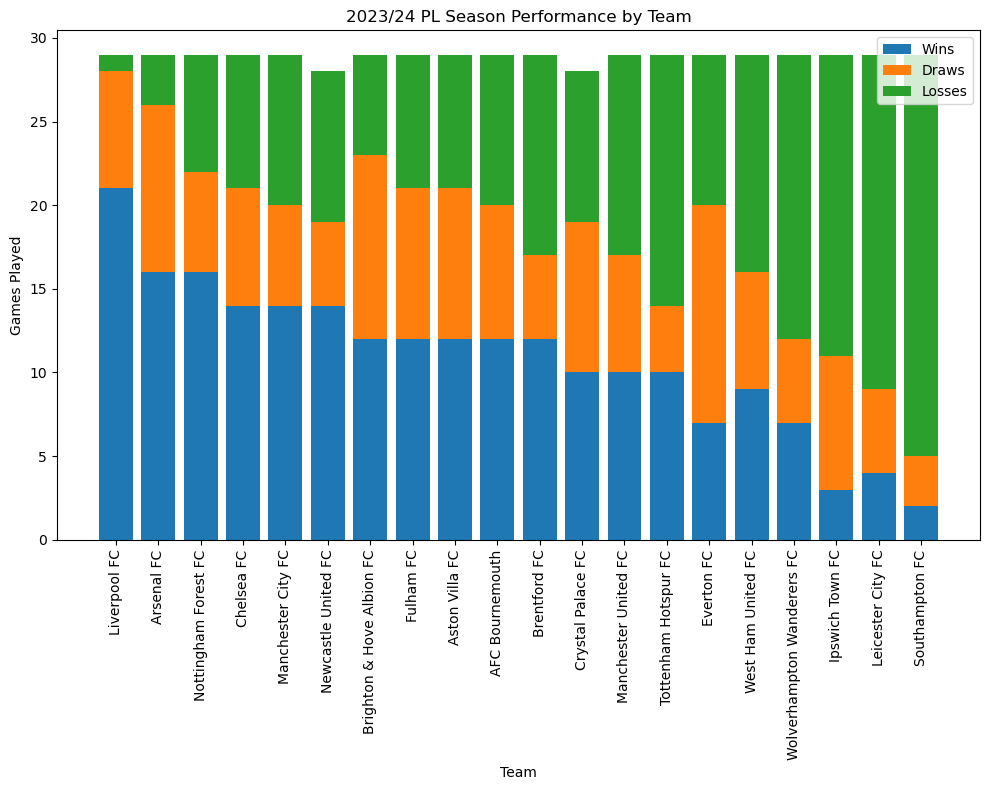

In [26]:
# Bar chart to visualize permormance metrics
plt.figure(figsize=(10, 8))
plt.bar(df_copy['Team'], df_copy['Won'], label='Wins')
plt.bar(df_copy['Team'], df_copy['Draw'], bottom=df_copy['Won'], label='Draws')
plt.bar(df_copy['Team'], df_copy['Lost'], bottom=df_copy['Won'] + df_copy['Draw'], label='Losses')
plt.xlabel('Team')
plt.ylabel('Games Played')
plt.title('2023/24 PL Season Performance by Team')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

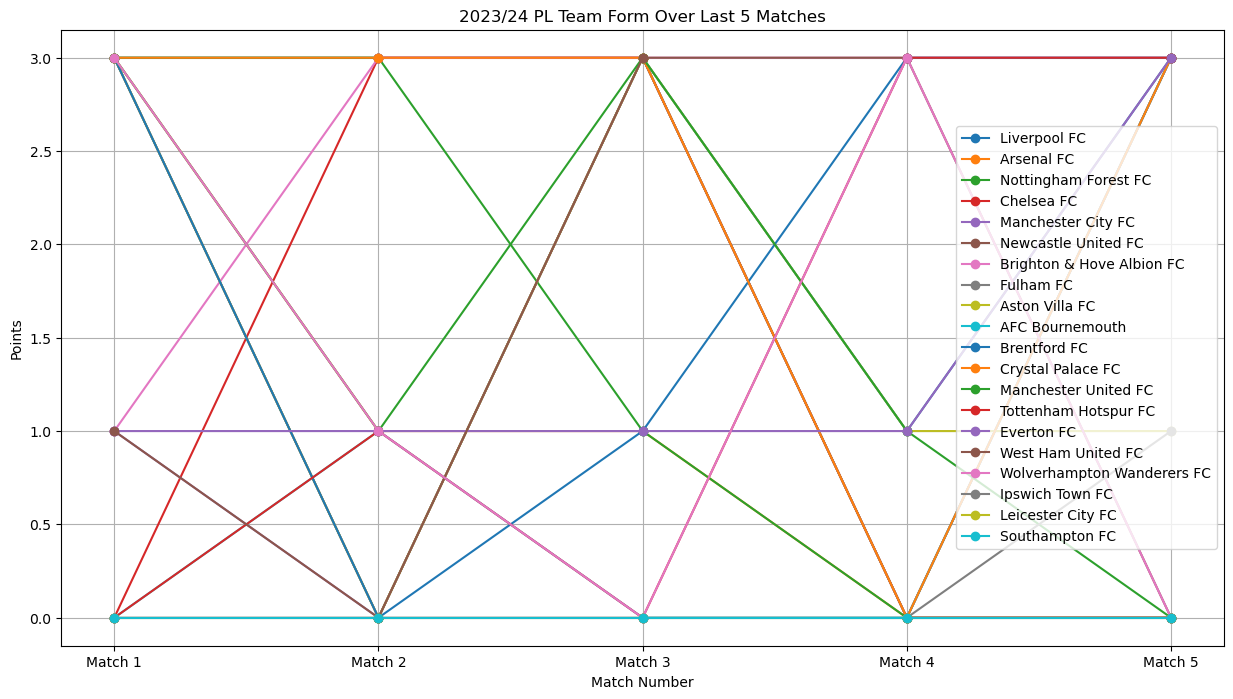

In [27]:
# Map form outcomes to numerical values
form_mapping = {'W': 3, 'D': 1, 'L': 0}

# Function to convert form string to numerical values
def convert_form_to_values(form_string):
    return [form_mapping[outcome] for outcome in form_string.split(',')]

# Apply conversion
df_copy['Form Values'] = df_copy['Form'].apply(convert_form_to_values)

# Plotting
plt.figure(figsize=(15, 8))

for index, row in df_copy.iterrows():
    plt.plot(row['Form Values'], label=row['Team'], marker='o')

plt.title('2023/24 PL Team Form Over Last 5 Matches')
plt.xlabel('Match Number')
plt.ylabel('Points')
plt.xticks(range(5), ['Match 1', 'Match 2', 'Match 3', 'Match 4', 'Match 5'])
plt.legend()
plt.grid(True)
plt.show()

## Data Exporting

The processed data is exported to both Excel and CSV formats. This allows analysts to perform further analysis using spreadsheet software or import the data into other analytical tools.

In [32]:
# File names
csv_file = 'plf_data.csv'
excel_file = 'plf_data.xlsx'

# Export to CSV
try:
    df_copy.to_csv(csv_file, index=False)
    print(f"Data exported to {csv_file}")
except PermissionError as e:
    print(f"Permission error while writing to {csv_file}: {e}")

# Export to Excel
try:
    df_copy.to_excel(excel_file, index=False, sheet_name='2024_25 PLF Data')
    print(f"Data exported to {excel_file}")
except PermissionError as e:
    print(f"Permission error while writing to {excel_file}: {e}")

Data exported to plf_data.csv
Data exported to plf_data.xlsx
